<a href="https://colab.research.google.com/github/DanielCalderon97/Proyecto_Final_Text_Minning_Image/blob/main/ProyectoFinal_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Problema 2
### Daniel Calderón - 24000152

#### Parte 1: Dataset

In [11]:
# Parametros que nos servirán durante todo el desarrollo

SEED = 2025
IMG_SIZE = (180, 180)       # (alto, ancho)
COLOR_MODE = "rgb"          # use el 'rgb'
BATCH_SIZE = 32
VAL_SPLIT = 0.20
TEST_SPLIT = 0.20
EPOCHS = 10
USE_AUGMENTATION = True
SAVE_TO_DRIVE = False

# Nombre de la carpeta principal dentro del ZIP
DATASET_DIR_NAME = "Fruits_Vegetables_Dataset(12000)"

print("Parámetros OK")

Parámetros OK


In [12]:
# Montamos Google Drive
# Ruta al archivo en tu Google Drive

from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, shutil

zip_path = "/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/archive.zip"
assert os.path.exists(zip_path), f"No se encontró: {zip_path}"
print("ZIP:", zip_path)

# Extraemos contenido

EXTRACT_DIR = "/content/dataset_full"
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(EXTRACT_DIR)
print("Descomprimido en:", EXTRACT_DIR)

# Declaramos rutas
DATA_ROOT = f"{EXTRACT_DIR}/{DATASET_DIR_NAME}"
FRUITS_DIR = f"{DATA_ROOT}/Fruits"
VEGGIES_DIR = f"{DATA_ROOT}/Vegetables"

for p in [DATA_ROOT, FRUITS_DIR, VEGGIES_DIR]:
    assert os.path.exists(p), f"Ruta no encontrada: {p}"
print("Fruits dir:", FRUITS_DIR)
print("Vegetables dir:", VEGGIES_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP: /content/drive/MyDrive/Colab Notebooks/ProyectoFinal/archive.zip
Descomprimido en: /content/dataset_full
Fruits dir: /content/dataset_full/Fruits_Vegetables_Dataset(12000)/Fruits
Vegetables dir: /content/dataset_full/Fruits_Vegetables_Dataset(12000)/Vegetables


In [13]:
# Mapa: [subcarpetas_de_origen]
# Para el trabajo escogí en Frutas: Manzana, Banano y Naranjas || y en Verduras: tomate, papa y zanahoria
# Unimos ambas carpetas de los alimentos: las imagenes "frescas" y las "podridas"

CLASS_MAP = {
    "Apple":  ["FreshApple",  "RottenApple"],
    "Banana": ["FreshBanana", "RottenBanana"],
    "Orange": ["FreshOrange", "RottenOrange"],
    "Carrot": ["FreshCarrot", "RottenCarrot"],
    "Potato": ["FreshPotato", "RottenPotato"],
    "Tomato": ["FreshTomato", "RottenTomato"],
}

print("Clases seleccionadas:", list(CLASS_MAP.keys()))

Clases seleccionadas: ['Apple', 'Banana', 'Orange', 'Carrot', 'Potato', 'Tomato']


In [14]:
# Construimos conjunto **RAW** con clases unificadas

import os, shutil, glob

RAW_DIR = "/content/data_raw"
if os.path.exists(RAW_DIR):
    shutil.rmtree(RAW_DIR)
os.makedirs(RAW_DIR, exist_ok=True)

def copy_merge_class(dst_class, subfolders):
    dst_dir = os.path.join(RAW_DIR, dst_class)
    os.makedirs(dst_dir, exist_ok=True)
    for sub in subfolders:
        # Determinar si la subcarpeta viene de Frutas o Vegetales
        src = None
        if os.path.exists(os.path.join(FRUITS_DIR, sub)):
            src = os.path.join(FRUITS_DIR, sub)
        elif os.path.exists(os.path.join(VEGGIES_DIR, sub)):
            src = os.path.join(VEGGIES_DIR, sub)
        else:
            raise FileNotFoundError(f"No existe subcarpeta: {sub} en Fruits/Vegetables")
        # Copiar imágenes
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
            for img in glob.glob(os.path.join(src, ext)):
                shutil.copy2(img, os.path.join(dst_dir, os.path.basename(img)))

for cls, subs in CLASS_MAP.items():
    copy_merge_class(cls, subs)

# Verificación rápida de la cantidad de imagenes por carpeta
for cls in sorted(os.listdir(RAW_DIR)):
    n = len(os.listdir(os.path.join(RAW_DIR, cls)))
    print(f"{cls:>8}: {n} imágenes")

   Apple: 1199 imágenes
  Banana: 1195 imágenes
  Carrot: 1199 imágenes
  Orange: 1200 imágenes
  Potato: 1198 imágenes
  Tomato: 1199 imágenes


In [15]:
# Split train/val/test (estratificado)

import random, math

BASE_DIR = "/content/data_split"
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(BASE_DIR, exist_ok=True)
for sp in ["train","val","test"]:
    os.makedirs(os.path.join(BASE_DIR, sp), exist_ok=True)

train_ratio = 1.0 - (VAL_SPLIT + TEST_SPLIT)
val_ratio   = VAL_SPLIT
test_ratio  = TEST_SPLIT
print(f"Ratios -> train={train_ratio:.2f}, val={val_ratio:.2f}, test={test_ratio:.2f}")

def stratified_split(class_dir, seed=SEED):
    imgs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
        imgs += glob.glob(os.path.join(class_dir, ext))
    imgs = sorted(imgs)
    rnd = random.Random(seed); rnd.shuffle(imgs)
    n = len(imgs)
    n_train = int(n*train_ratio); n_val = int(n*val_ratio)
    return imgs[:n_train], imgs[n_train:n_train+n_val], imgs[n_train+n_val:]

def copy_files(files, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for src in files:
        shutil.copy2(src, os.path.join(dst_dir, os.path.basename(src)))

counts = {}
for cls in sorted(os.listdir(RAW_DIR)):
    src_cls_dir = os.path.join(RAW_DIR, cls)
    tr, va, te = stratified_split(src_cls_dir, seed=SEED)
    counts[cls] = dict(train=len(tr), val=len(va), test=len(te), total=len(os.listdir(src_cls_dir)))
    copy_files(tr, os.path.join(BASE_DIR, "train", cls))
    copy_files(va, os.path.join(BASE_DIR, "val", cls))
    copy_files(te, os.path.join(BASE_DIR, "test", cls))

print("Conteos por clase:")
for k,v in counts.items():
    print(f"{k:>8} -> train={v['train']}, val={v['val']}, test={v['test']} (total={v['total']})")

Ratios -> train=0.60, val=0.20, test=0.20
Conteos por clase:
   Apple -> train=719, val=239, test=241 (total=1199)
  Banana -> train=717, val=239, test=239 (total=1195)
  Carrot -> train=719, val=239, test=241 (total=1199)
  Orange -> train=720, val=240, test=240 (total=1200)
  Potato -> train=718, val=239, test=241 (total=1198)
  Tomato -> train=719, val=239, test=241 (total=1199)


In [16]:
# Generators + Data Augmentation

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if USE_AUGMENTATION:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15, height_shift_range=0.15,
        zoom_range=0.2, shear_range=0.15,
        horizontal_flip=True,
        brightness_range=(0.8,1.2),
        fill_mode="nearest"
    )
else:
    train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Clases:", class_indices)

Found 4301 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1442 images belonging to 6 classes.
Clases: {'Apple': 0, 'Banana': 1, 'Carrot': 2, 'Orange': 3, 'Potato': 4, 'Tomato': 5}


In [17]:
# Modelo CNN
from tensorflow.keras import layers, models, callbacks, optimizers

channels = 3 if COLOR_MODE=="rgb" else 1
input_shape = (IMG_SIZE[0], IMG_SIZE[1], channels)

def build_cnn(input_shape, num_classes):
    x_in = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x_in)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(x_in, out, name="FruitsVeg_CNN_paths")

model = build_cnn(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "FruitsVeg_CNN_paths"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,006 (1.62 MB)

 Trainable params: 423,046 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
#Entrenamiento

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_gen, validation_data=val_gen,
    epochs=EPOCHS, callbacks=[es, rlr], verbose=1
)
print("Entrenamiento finalizado.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 20/135 ━━━━━━━━━━━━━━━━━━━━ 1:03 556ms/step - accuracy: 0.2892 - loss: 2.0213

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 428ms/step - accuracy: 0.3981 - loss: 1.5986 - val_accuracy: 0.1668 - val_loss: 3.2067 - learning_rate: 0.0010
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 56s 411ms/step - accuracy: 0.6345 - loss: 1.0366 - val_accuracy: 0.1675 - val_loss: 4.2480 - learning_rate: 0.0010
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.6796 - loss: 0.8791 - val_accuracy: 0.2945 - val_loss: 2.6512 - learning_rate: 0.0010
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.7515 - loss: 0.7164 - val_accuracy: 0.3824 - val_loss: 2.3056 - learning_rate: 0.0010
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.7808 - loss: 0.6291 - val_accuracy: 0.7153 - val_loss: 0.8195 - learning_rate: 0.0010
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.8010 - loss: 0.5812 - val_accuracy: 0.7606 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/step - accuracy: 0.8180 - loss:

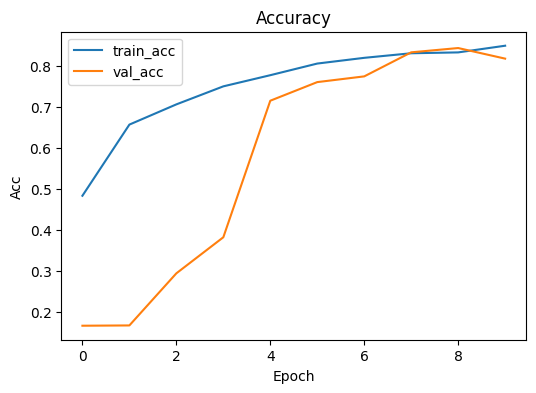

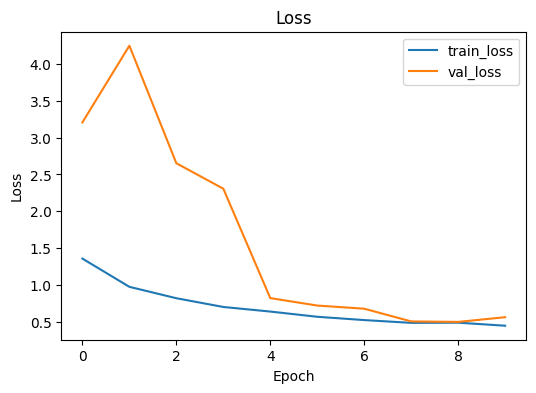

Test accuracy: 0.8481 | loss: 0.4385

Classification Report:
              precision    recall  f1-score   support

       Apple       0.88      0.71      0.79       240
      Banana       0.79      0.93      0.85       239
      Carrot       0.82      0.89      0.85       241
      Orange       0.91      0.84      0.87       240
      Potato       0.79      0.89      0.84       241
      Tomato       0.94      0.83      0.88       241

    accuracy                           0.85      1442
   macro avg       0.85      0.85      0.85      1442
weighted avg       0.86      0.85      0.85      1442



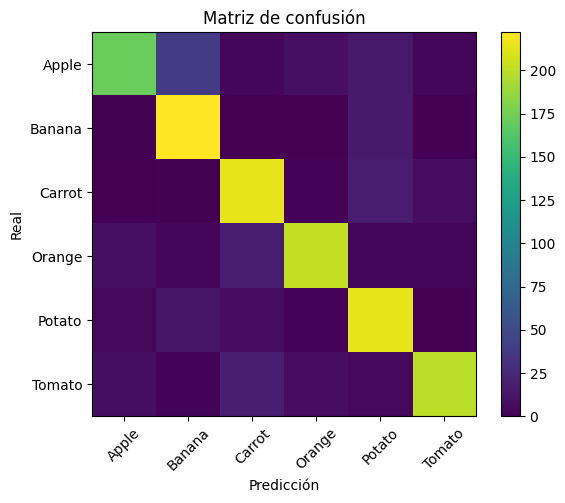

In [19]:
# Curvas, evaluación y matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Curvas
hist = history.history
plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Test
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

probs = model.predict(test_gen, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = test_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.title("Matriz de confusión"); plt.colorbar()
ticks = np.arange(len(idx_to_class))
plt.xticks(ticks, [idx_to_class[i] for i in ticks], rotation=45)
plt.yticks(ticks, [idx_to_class[i] for i in ticks])
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout(); plt.show()
